## 今天的範例，帶著大家一起挖掘變數之間的關係

In [1]:
# library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics
import seaborn as sns
from IPython.display import display
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline


0.22.1


## 產生一組資料集

In [2]:
#用字典產生一組資料
data={'sex': ['Male','Male','Male','Male','Male','Female','Female','Female','Female','Female','Male','Male','Male','Male','Male','Female','Female','Female','Female','Female'],
      'insomnia':['Y','N','N','N','N','N','Y','Y','Y','N','Y','N','N','N','N','N','Y','Y','Y','N'],
     'age':[23,40,5,30,1,40,16,27,43,8,23,39,5,29,1,42,13,29,41,10],
     'height':[180,170,100,176,70,160,170,166,155,35,170,168,101,175,72,163,169,163,151,40],
     'weight':[100,68,20,70,10,45,50,58,58,17,101,65,22,79,12,40,53,52,56,14]}
#轉成 dataframe格式 
data=pd.DataFrame(data)
display(data)

print(data.info())

,sex,insomnia,age,height,weight
0,Male,Y,23,180,100
1,Male,N,40,170,68
2,Male,N,5,100,20
3,Male,N,30,176,70
4,Male,N,1,70,10
5,Female,N,40,160,45
6,Female,Y,16,170,50
7,Female,Y,27,166,58
8,Female,Y,43,155,58
9,Female,N,8,35,17


TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [3]:
cat_features = []
for dtype, feature in zip(data.dtypes, data.columns):
    if dtype == 'object':
        cat_features.append(feature)
print(f'{len(cat_features)} category Features : {cat_features}\n')

2 category Features : ['sex', 'insomnia']



## 連續 vs 連續
  本範例透過 Pearson相關係數，看身高和體重相關性
* Pearson相關係數
   是描述兩個連續型變數的相關性
* 語法: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [4]:
# 由於 pearsonr 有兩個回傳結果，我們只需取第一個回傳值為相關係數
corr, _=stats.pearsonr(data['height'], data['weight'])
print(corr)
#代表身高和體重有高度線性相關

0.838087958076245


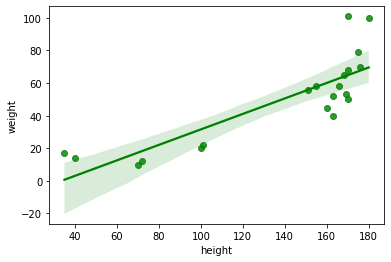

In [5]:
g = sns.regplot(x="height", y="weight", color="g",data=data)
#年齡和身高有關連

## 離散 vs 離散
  本範例透過 Cramér's V ，看失眠的狀態和性別相關性

In [6]:
#如果沒有安裝過，先把下一行程式碼打開，先安裝套件 
#!pip install researchpy

import researchpy   
# https://researchpy.readthedocs.io/

## step1: 用交叉列連表(contingency table)，來整理兩個類別型的資料

In [7]:
contTable = pd.crosstab(data['sex'], data['insomnia'])
contTable

insomnia,N,Y
sex,,
Female,4,6
Male,8,2


## Step2:計算資料自由度 df*


In [8]:
df = min(contTable.shape[0], contTable.shape[1]) - 1
df

1

## Step3:運用 researchpy 套件，計算出 Cramer’s V 係數


In [9]:
crosstab, res = researchpy.crosstab(data['sex'], data['insomnia'], test='chi-square')
#print(res)
print("Cramer's value is",res.loc[2,'results'])

#這邊用卡方檢定獨立性，所以採用的 test 參數為卡方 "test =" argument.
# 採用的變數在這個模組中，會自己根據資料集來判斷，Cramer's Phi if it a 2x2 table, or Cramer's V is larger than 2x2.

Cramer's value is 0.4082


In [10]:
## 寫一個副程式判斷相關性的強度
def judgment_CramerV(df,V):
    if df == 1:
        if V < 0.10:
            qual = 'negligible'
        elif V < 0.30:
            qual = 'small'
        elif V < 0.50:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 2:
        if V < 0.07:
            qual = 'negligible'
        elif V < 0.21:
            qual = 'small'
        elif V < 0.35:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 3:
        if V < 0.06:
            qual = 'negligible'
        elif V < 0.17:
            qual = 'small'
        elif V < 0.29:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 4:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.15:
            qual = 'small'
        elif V < 0.25:
            qual = 'medium'
        else:
            qual = 'large'
    else:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.13:
            qual = 'small'
        elif V < 0.22:
            qual = 'medium'
        else:
            qual = 'large'
    return(qual)

judgment_CramerV(df,res.loc[2,'results'])

'medium'

### 此案例的失眠狀態和性別這兩個變數，呈現中度相關

## 搭配圖形觀察

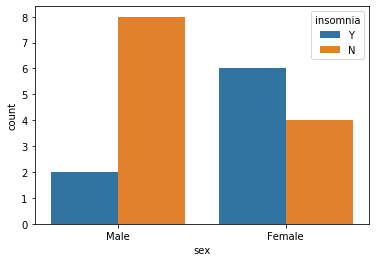

In [11]:
g= sns.countplot(x="sex", hue="insomnia", data=data)

## 離散 vs 連續 Eta Squared(η2)
  本範例透過 Eta Squared ，看失眠的狀態和體重相關性

In [13]:
#如果沒有安裝過，先把下一行程式碼打開，先安裝套件
#!pip install pingouin --user
import pingouin as pg

### Step1: 取出失眠和體重資料
###  Step2:運用 pg.anova 計算三種變異數

In [14]:
aov = pg.anova(dv='weight', between='insomnia', data=data, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,insomnia,3630.0,1,3630.000000,6.123137,0.023521,0.253828
1,Within,10671.0,18,592.833333,NaN,NaN,NaN


### Step3:變異數換算得到 Eta Squared (𝜼^𝟐)

In [15]:
etaSq = aov.SS[0] / (aov.SS[0] + aov.SS[1])
etaSq

0.2538284036081393

In [16]:
def judgment_etaSq(etaSq):
    if etaSq < .01:
        qual = 'Negligible'
    elif etaSq < .06:
        qual = 'Small'
    elif etaSq < .14:
        qual = 'Medium'
    else:
        qual = 'Large'
    return(qual)
judgment_etaSq(etaSq)

'Large'

### 搭配圖形來檢視
* 這邊使用小提琴圖示法

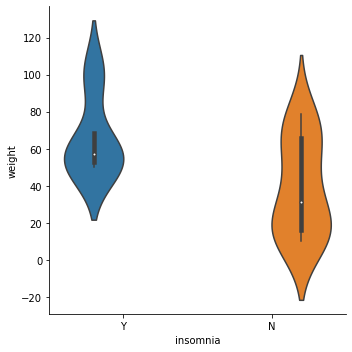

In [17]:
g = sns.catplot(x="insomnia", y="weight", hue="insomnia",
               data=data, kind="violin")

### 結論: 體重和失眠狀態有高度相關性，有失眠狀態的體重較非失眠狀態來的大。